# Rocket System and Its Response

Some fancy text here describing why this is such a cool example of controls...

In this first block, functions are defined to compute the motion of the booster, including the system model which computes the rate of change of the state from the existing state, and an integrator which integrates the rate of change to find the new state after a small time.

You normally don't need to edit code in this section.

In [2]:
# Numpy is Python package dealing with numerical computations related to n-dimensional arrays.
# A smaller but similar package, ulab, is available for MicroPython.
import numpy as np 

def dx(x, u):
    """ Compute the derivative of the state from the current state.
    @param x The state variable, representing tilt angle
    @param u The control input, torque caused by vectoring the rocket thrust
    """
    # Assemble the state space form dx = Ax + bu
    g = 9.81   # kg m/s^2
    l = 5     # rocket length
    m = 200    # 200 kg
    dotx = np.array([x[1],  -g/l*np.sin(x[0]) -0.8*x[1] + u/m]) # light damping is added to the system
    return dotx


def getNextResponse(dt, x, u):
    """ A 4th-order Runge-Kutta integrator used to simulate system dynamics.
    @param dt The time interval over which we're integrating
    @param x  The current state, representing tilt angle
    @param u The control input, torque caused by vectoring the rocket thrust
    """
    k1 = dx(x,         u)
    k2 = dx(x+k1*dt/2, u)
    k3 = dx(x+k2*dt/2, u)
    k4 = dx(x+k3*dt,   u)
    
    return x + 1/6*(k1 + 2*k2 + 2*k3 + k4) * dt


def plotResponse(output, tf):
    """ Plot the angle, rate of angular change, and actuation torque vs. time.
    @param output An array of responses: [time, angle, angular_rate, actuation]
           where each element in the output array is an array of values
    """
    import matplotlib.pyplot as plt
    p1=plt.figure()
    plt.plot(output[:,0],output[:,1]) # output[:,0] time, output[:,1] angle
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (rad)")         # Does zero mean the rocket is pointing down?
    plt.hlines(np.pi, 0, tf, colors='k', linestyles='dashed')
    plt.hlines(x0[0], 0, tf, colors='k', linestyles='dashed')
    plt.text(10, x0[0], 'Initial angle', va='top')
    plt.show()

    p2=plt.figure()
    plt.plot( output[:,0],output[:,2]) # output[:,1] angular velocity
    plt.xlabel("Time (s)")
    plt.ylabel("Angular Rate (rad/s)")
    plt.hlines(0, 0, tf, colors='k', linestyles='dashed')
    plt.show()

    p3=plt.figure()
    plt.xlabel("Time (s)")
    plt.ylabel("Actuation (TUs)")     # Torque Units?
    plt.plot(output[:,0],output[:,3]) # output[:,2] input u
    plt.hlines(0, 0, tf, colors='k', linestyles='dashed')
    plt.show()


# The following variables need to be initialized once before the system runs
N = 10000 # number of sample points
t0 = 0 # initial time
output = np.empty((N, 4)) # allocate the memory for output.
I = np.identity(2) # identity matrix

# Initial conditions. The first element is angle, the second is angular velocity.
x0 = np.array([[-0.1 + np.pi], [0]])


# Configuration of Control System and Main Loop
In the following block, the control system gains are set and then the main simulation loop is run, then the result is plotted.

Peak angle is 3.041592653589793
Final angle is 2.74418874060665e-06


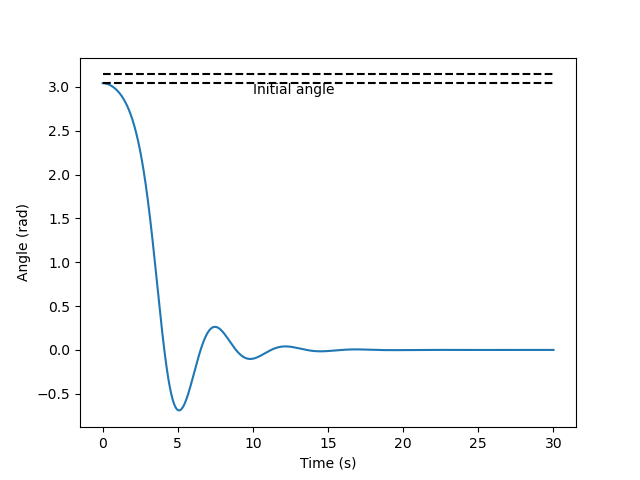

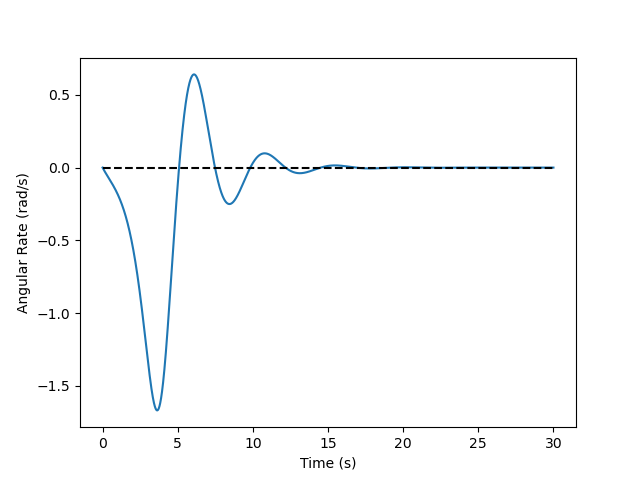

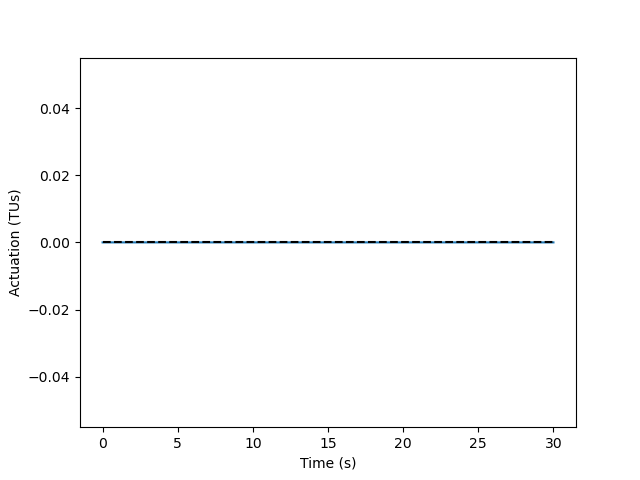

In [3]:
# Control system configuration
tf = 30 # final time
dt = (tf - t0) / N # closed-loop sampling time

# Controller configuration
Kp = 200   # proportional gain
Kd = 0 # derivative gain 

# Desired angle
x_desired = np.pi 

# Initialize variables for angle and time before running the loop
x, t = x0, 0

# The main simulation loop. The derivative of angle and change in angle are computed 
# for each time step.
for i in range(N):
    #MODIFY THIS LINE TO CALCULATE error AND derror.
    #See the manual on how to find x and x_dot.
    
    # MODIFY THIS LINE TO CALCULATE CONTROLLER OUTPUT u
    u = 0
    x_next = getNextResponse(dt, x, u)  # Compute the output after one more time step

    y = I @ x           # Get measured output: disp and velc. y = Cx + Du. C = I, D = 0

    # Record time, response, and controller output
    output[i] = np.hstack((t + dt, *y, u))

    # Set up for the next iteration
    x = x_next
    t += dt


peak_angle = max(output[:,1])
print("Peak angle is", peak_angle)

final_angle = output[:,1][-1]
print("Final angle is", final_angle)

# When the simulation is finished, plot the results
plotResponse(output, tf)

# Animator

This is the animator to show the landing process. You don't need to make any changes to this section.

In [4]:
import pygame

pygame.init()
screensize =[600, 600]
screen = pygame.display.set_mode(screensize)

pygame.display.set_caption('Rocket Booster Landing Exercise')
clock = pygame.time.Clock()

# Load the rocket, rescale it, place it at the middle top.
rocket = pygame.image.load('PolyX.png').convert()
DEFAULT_IMAGE_SIZE = (150, 200)
rocket = pygame.transform.scale(rocket, DEFAULT_IMAGE_SIZE)
rocket = pygame.transform.flip(rocket, True, True)
rocket_rect = rocket.get_rect(midtop = screen.get_rect().midtop)

# Landing Pad
LANDING_PAD_SIZE = (600, 50)
landingPad = pygame.image.load('Landing Pad.png').convert()
landingPad = pygame.transform.scale(landingPad, LANDING_PAD_SIZE)
landingPad_rect = landingPad.get_rect(midbottom = screen.get_rect().midbottom)

# Final vertical position of the rocket
final_y = screensize[1] -DEFAULT_IMAGE_SIZE[1] - 20
ts = tf / 4

position = rocket_rect
done = False
for time, angle in zip(output[0:-1:10,0], [x * 180 / np.pi for x in output[0:-1:10,1]]):
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            done = True

    # Rotate image
    rot_rocket = pygame.transform.rotate(rocket, angle)

    # Move image
    position.y = final_y - final_y*np.exp(-1 / ts * time)

    rocket_rect = rot_rocket.get_rect(center = position.center)

    # Copy image to screen
    screen.fill((255, 255, 255))
    screen.blit(rot_rocket, rocket_rect)
    screen.blit(landingPad, landingPad_rect)
    pygame.display.flip()

    clock.tick(60)
    
    if done:
        break

pygame.quit()

pygame 2.6.1 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


2024-12-26 10:42:25.834 python[9675:97752] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-26 10:42:25.834 python[9675:97752] +[IMKInputSession subclass]: chose IMKInputSession_Modern
